In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [147]:
#!/usr/bin/env python3
from abc import ABC
from abc import abstractmethod
from collections import defaultdict
from pathlib import Path
from typing import Dict

import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from multicam import plotting as rxplots
from multicam.correlations import add_box_indices
from multicam.correlations import get_2d_corr
from multicam.correlations import spearmanr
from multicam.correlations import vol_jacknife_err
from multicam.cosmo import get_a_from_t
from multicam.cosmo import get_fractional_tdyn
from multicam.cosmo import get_t_from_a
from multicam.fits import alpha_analysis
from multicam.fits import get_early_late
from multicam.gradients import get_savgol_grads
from multicam.mah import get_an_from_am
from multicam.mah import get_mah
from multicam.models import opcam_dict
from multicam.models import prepare_datasets
from multicam.models import training_suite
from multicam.plotting import CB_COLORS
from multicam.plotting import MARKS
from multicam.plotting import set_rc

In [148]:
mahdir = "../../data/processed/bolshoi_m12"
mah_data = get_mah(mahdir, cutoff_missing=0.05, cutoff_particle=0.05, log_mbin_spacing=False)

In [149]:
params = ("cvir", "t/|u|", "x0", "spin_bullock", "c_to_a")

In [150]:
cat = mah_data["cat"]
ma = mah_data["ma_peak"]
am = mah_data["am"]
mass_bins = mah_data["mass_bins"][:-1]  # remove last bin to avoid spearman error.
scales = mah_data["scales"][:-1]  # same for scales.
n_mbins = len(mass_bins)
n_scales = len(scales)
add_box_indices(cat)

# load diffmah parameters of best fits.
pars = np.load("../../data/processed/pbest_diffmah.npy")
logtc, ue, ul = pars[:, 0], pars[:, 1], pars[:, 2]
early, late = get_early_late(ue, ul)
cat.add_column(10**logtc, name="tau_c")
cat.add_column(early, name="alpha_early")
cat.add_column(late, name="alpha_late")


# prepare catalog with all m_a
ma_names = [f"ma_{ii}" for ii in range(len(scales))]
for ii in range(len(scales)):
    cat.add_column(ma[:, ii], name=ma_names[ii])


In [151]:
rng = np.random.default_rng(42)

In [158]:
# "alpha_late", "tau_c" are different
# "alpha_early", "tau_c" are same except for xoff
# "alpha_early", "alpha_late" are all different
info = {
    "params_diffmah": {
        "x": ("alpha_late", "alpha_early", "tau_c"),
        "y": params,
    },
}
datasets, _, cat_test = prepare_datasets(cat, info, rng, test_ratio=0.3)
n_params = len(params)

In [159]:
datasets["params_diffmah"]["train"][0].shape, datasets["params_diffmah"]["test"][0].shape


((7000, 3), (3000, 3))

In [160]:
data = {
    "rpdiff": {
        "xy": datasets["params_diffmah"]["train"],
        "n_features": 3,
        "n_targets": 5,
        "model": "linear",
        "kwargs": {"use_multicam": True},
    },

        "nrpdiff": {
        "xy": datasets["params_diffmah"]["train"],
        "n_features": 3,
        "n_targets": 5,
        "model": "linear",
        "kwargs": {"use_multicam_no_ranks": True, "use_multicam": False},
    },
}

models = training_suite(data)

In [161]:
x_train, y_train = datasets['params_diffmah']["train"]
x_test, y_test = datasets['params_diffmah']["test"]


In [162]:
y_pred1 = models['rpdiff'].predict(x_test)
y_pred2 = models['nrpdiff'].predict(x_test)

7000 3000 6999
7000 3000 6999
7000 3000 6999
7000 3000 6999
7000 3000 6999


In [163]:

for ii in range(3):
    print(("cvir", "c_to_a", "x0")[ii])
    print(spearmanr(y_pred1[:, ii], y_test[:, ii]))
    print(spearmanr(y_pred2[:, ii], y_test[:, ii]))
    print()

cvir
0.6533004645889403
0.6541905162433906

c_to_a
0.6002341626831535
0.6004466097746243

x0
0.556550403172267
0.5566050120672235



In [79]:
print(len(cat['cvir']))
print(len(np.unique(cat['cvir'])))

10000
9994


In [72]:
print(len(cat['t/|u|']))
print(len(np.unique(cat['t/|u|'])))

10000
1293


In [78]:
len(np.unique(cat['id'].value))

10000

In [74]:
print(np.sort(cat['t/|u|'])[:50])


       t/|u|       
-------------------
 0.4957999885082245
0.49900001287460327
 0.5026000142097473
 0.5054000020027161
 0.5059999823570251
 0.5080000162124634
 0.5085999965667725
 0.5088000297546387
 0.5091999769210815
 0.5108000040054321
                ...
 0.5170000195503235
 0.5170000195503235
 0.5171999931335449
  0.517799973487854
  0.517799973487854
 0.5180000066757202
 0.5180000066757202
 0.5180000066757202
 0.5181999802589417
 0.5181999802589417
 0.5184000134468079
Length = 50 rows
      t/|u|       
------------------
0.8677999973297119
0.8682000041007996
0.8718000054359436
0.8726000189781189
0.8766000270843506
0.8849999904632568
0.8980000019073486
0.9002000093460083
0.9047999978065491
0.9053999781608582
               ...
1.0772000551223755
 1.083400011062622
1.0947999954223633
1.1061999797821045
1.1136000156402588
1.1446000337600708
1.1549999713897705
1.2654000520706177
 1.292199969291687
1.3306000232696533
 1.408400058746338
Length = 50 rows


In [71]:
print(len(cat['c_to_a']))
print(len(np.unique(cat['c_to_a'])))

10000
9012


In [70]:
print(len(cat['x0']))
print(len(np.unique(cat['x0'])))

10000
9999


In [69]:
print(len(cat['spin_bullock']))
print(len(np.unique(cat['spin_bullock'])))

10000
5709


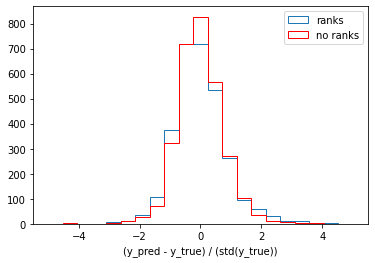

In [73]:
_, bins, _ = plt.hist((y_pred1[:, 0] - y_test[:, 0]) / np.std(y_test[:, 0]), histtype='step', bins=21, range=(-5, 5), label='ranks')
plt.hist((y_pred2[:, 0] - y_test[:, 0]) / np.std(y_test[:, 0]), histtype='step', bins=bins, color='r', range=(-5, 5), label='no ranks')
plt.xlabel("(y_pred - y_true) / (std(y_true))")
plt.legend()

(array([1.860e+02, 7.630e+02, 1.263e+03, 6.360e+02, 1.120e+02, 2.300e+01,
        6.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1.01379073,  4.33603172,  7.65827271, 10.9805137 , 14.30275469,
        17.62499568, 20.94723667, 24.26947766, 27.59171865, 30.91395964,
        34.23620063, 37.55844162, 40.88068261, 44.2029236 , 47.52516459,
        50.84740558, 54.16964657, 57.49188756, 60.81412855, 64.13636954,
        67.45861053]),
 [<matplotlib.patches.Polygon at 0x7fe430bf71c0>])

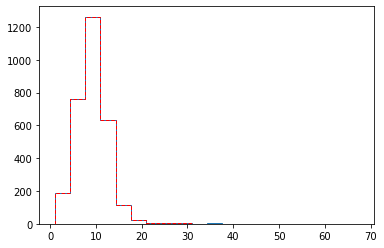

In [51]:
_, bins, fig = plt.hist(y_pred1[:, 0], bins=20, histtype='step')
plt.hist(y_pred2[:, 0], bins=bins, histtype='step', ls='--', color='r')

(array([2255., 2052., 1225., 1018.,  784.,  468.,  349.,  227.,  155.,
         133.,   93.,   94.,   44.,   62.,   37.,   41.,   39.,   36.,
          38.,   30.,   17.,   10.,   21.,   22.,   21.,   18.,   16.,
          17.,   10.,   11.,   11.,    8.,   12.,    8.,    7.,   15.,
           7.,    7.,   12.,    9.,    8.,    9.,    9.,    8.,    4.,
          15.,    7.,    3.,    4.,    7.,    6.]),
 array([ 0.        ,  0.98039216,  1.9607843 ,  2.9411764 ,  3.9215686 ,
         4.901961  ,  5.882353  ,  6.8627453 ,  7.8431373 ,  8.823529  ,
         9.803922  , 10.784314  , 11.764706  , 12.745098  , 13.725491  ,
        14.705882  , 15.686275  , 16.666666  , 17.647058  , 18.62745   ,
        19.607843  , 20.588236  , 21.568628  , 22.549019  , 23.529411  ,
        24.509804  , 25.490196  , 26.470589  , 27.450981  , 28.431372  ,
        29.411764  , 30.392157  , 31.37255   , 32.35294   , 33.333332  ,
        34.313725  , 35.294117  , 36.27451   , 37.2549    , 38.235294  ,
        3

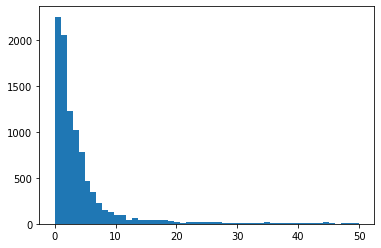

In [58]:
plt.hist(cat['tau_c'], bins=51, range=(0, 50))

(array([0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 5.400e+01, 1.730e+02,
        3.900e+02, 9.740e+02, 1.161e+03, 1.163e+03, 1.014e+03, 1.042e+03,
        8.360e+02, 5.950e+02, 4.670e+02, 3.600e+02, 3.170e+02, 2.710e+02,
        2.520e+02, 1.990e+02, 2.140e+02, 2.460e+02, 1.560e+02, 7.800e+01,
        2.800e+01, 8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 0.        ,  0.19607843,  0.39215687,  0.5882353 ,  0.78431374,
         0.98039216,  1.1764706 ,  1.372549  ,  1.5686275 ,  1.7647059 ,
         1.9607843 ,  2.1568627 ,  2.3529413 ,  2.5490196 ,  2.745098  ,
         2.9411764 ,  3.137255  ,  3.3333333 ,  3.5294118 ,  3.72549   ,
         3.9215686 ,  4.117647  ,  4.3137255 ,  4.509804  ,  4.7058825 ,


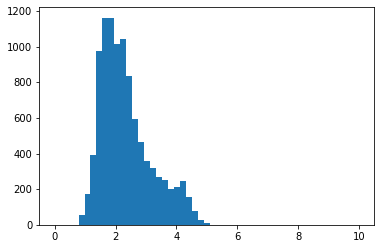

In [70]:
plt.hist(cat['alpha_early'], bins=51, range=(0, 10))

(array([ 64., 301., 919., 648., 546., 593., 679., 423., 352., 314., 269.,
        237., 217., 220., 221., 204., 192., 185., 187., 182., 163., 125.,
        137., 141., 123., 135.,  98.,  93., 111.,  92.,  93.,  75.,  87.,
         71.,  81.,  71.,  58.,  62.,  77.,  70.,  65.,  57.,  57.,  55.,
         52.,  52.,  50.,  43.,  49.,  48.,  47.]),
 array([0.        , 0.01960784, 0.03921569, 0.05882353, 0.07843138,
        0.09803922, 0.11764706, 0.13725491, 0.15686275, 0.1764706 ,
        0.19607843, 0.21568628, 0.23529412, 0.25490198, 0.27450982,
        0.29411766, 0.3137255 , 0.33333334, 0.3529412 , 0.37254903,
        0.39215687, 0.4117647 , 0.43137255, 0.4509804 , 0.47058824,
        0.49019608, 0.50980395, 0.5294118 , 0.54901963, 0.5686275 ,
        0.5882353 , 0.60784316, 0.627451  , 0.64705884, 0.6666667 ,
        0.6862745 , 0.7058824 , 0.7254902 , 0.74509805, 0.7647059 ,
        0.78431374, 0.8039216 , 0.8235294 , 0.84313726, 0.8627451 ,
        0.88235295, 0.9019608 , 0.921568

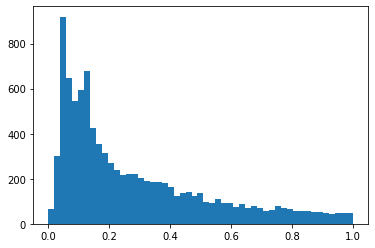

In [72]:
plt.hist(cat['alpha_late'], bins=51, range=(0, 1))

In [9]:
for name in ['tau_c', 'alpha_early', 'alpha_late']:
    print(name)
    print(len(cat[name]))
    print(len(np.unique(cat[name])))
    print()

tau_c
10000
10000

alpha_early
10000
10000

alpha_late
10000
9986

